In [27]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image, ImageFilter, ImageStat
from skimage.io import imshow, imread
from skimage.color import rgb2yuv, rgb2hsv, rgb2gray, yuv2rgb, hsv2rgb
from scipy.signal import convolve2d
from timebudget import timebudget
from multiprocessing import Pool
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import joblib
from p_tqdm import p_map, p_umap, p_imap, p_uimap
%matplotlib inline

## Testing various Blur functions to generate synthetic data from input clear images

In [3]:
img_path = r'C:\Concat\blur_detection\input'
img_files = glob.glob(os.path.join(img_path, '*.jpg'))

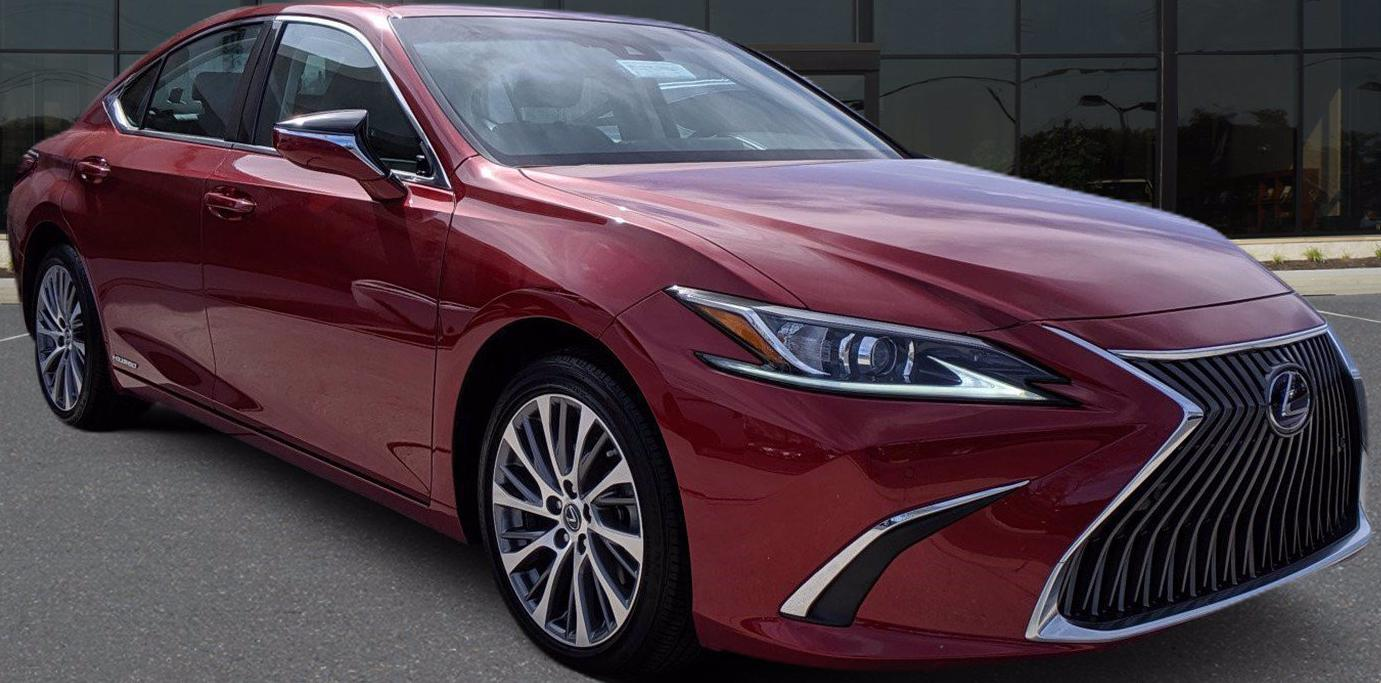

In [16]:
# Ground truth image
img = Image.open(img_files[1220])
img

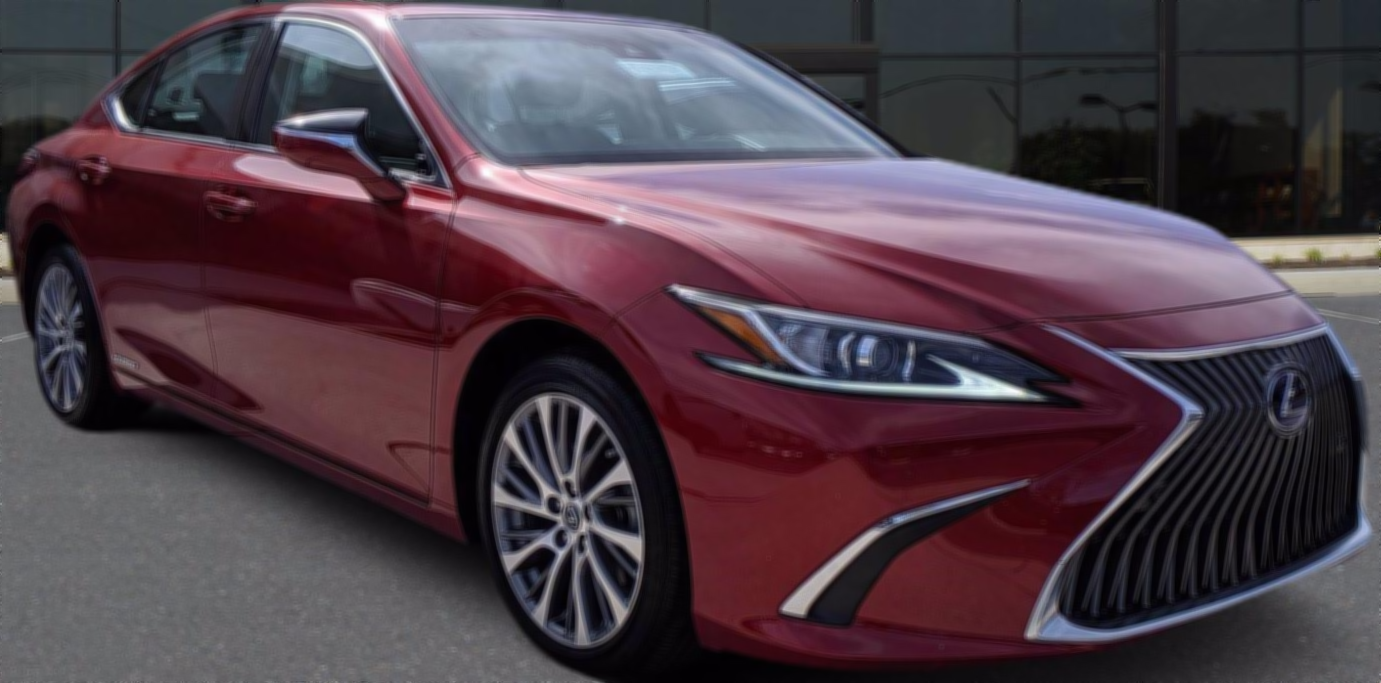

In [17]:
# blurred image generated using PIL simple BLur filter
blur_img_1 = img.filter(ImageFilter.BLUR)
blur_img_1

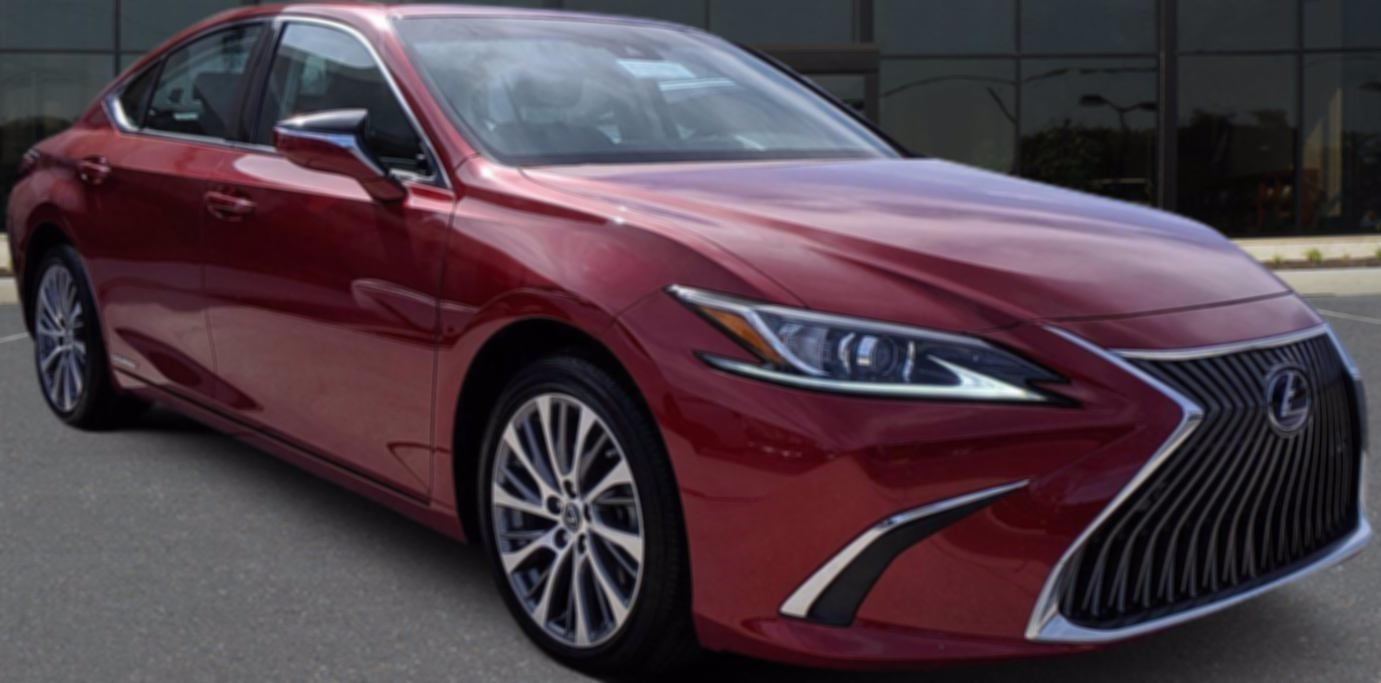

In [18]:
# blurred image generated using PIL Box BLur filter and we can set radius to different values 
blur_img_2 = img.filter(ImageFilter.BoxBlur(2))
blur_img_2

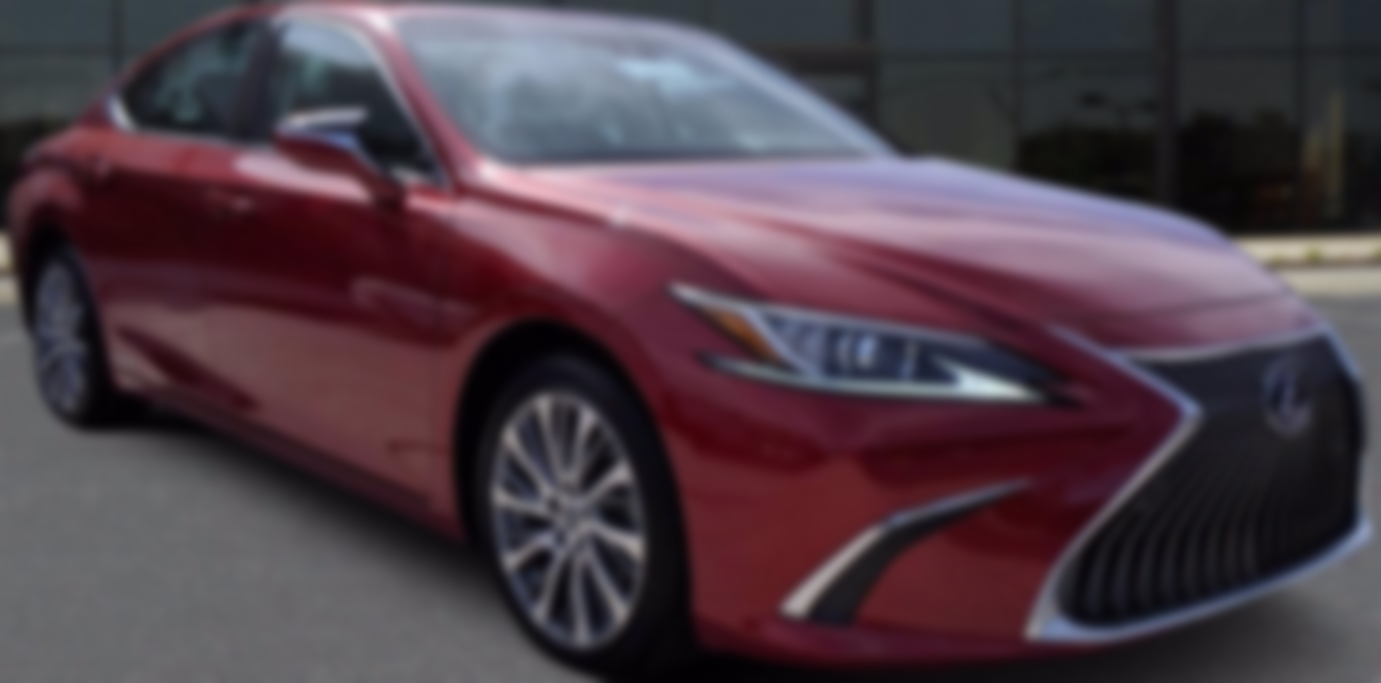

In [20]:
# blurred image generated using PIL gaussian BLur filter and we can set radius to different values 
blur_img_3 = img.filter(ImageFilter.GaussianBlur(radius=5))
blur_img_3

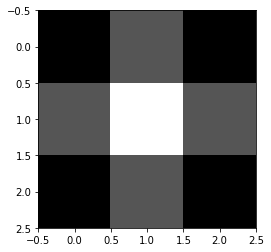

In [6]:
#Gaussian Blur
gaussian = (1/16)*np.array([[1., 2., 1,],
                            [2., 4., 2.],
                            [1., 2., 1.]])

plt.imshow(gaussian, cmap='gray')

In [45]:
car_img = imread(img_files[1])
img_gray = rgb2gray(car_img)

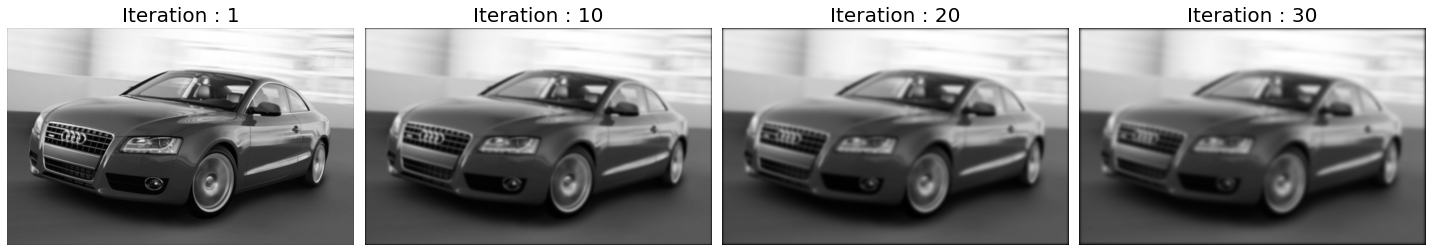

In [46]:
def multi_convolver(image, kernel, iterations):
    for i in range(iterations):
        image = convolve2d(image, kernel, 'same', boundary='fill', fillvalue=0)
    return image

def convolution_plotter(image, kernel):
    iterations=[1,10,20,30]
    fig, ax = plt.subplots(1,4, figsize=(20,7))
    for n,ax, in enumerate(ax.flatten()):
        ax.set_title(f'Iteration : {iterations[n]}',fontsize=20)
        ax.imshow(multi_convolver(image, kernel, iterations[n]), 
                  cmap='gray')
        ax.set_axis_off()
    fig.tight_layout()

convolution_plotter(img_gray, gaussian)

In [20]:
#img_list = glob.glob('C:\Concat\blur_detection\input\*.jpg')
path = r'C:\Concat\blur_detection\input'
out_folder = r'C:\Concat\blur_detection\output\\'
img_list = os.listdir(path)
len(img_list)

20044

In [ ]:
'''
with Pool(processes=10) as p:
        max_ = len(img_list)
        with tqdm(total=max_) as pbar:
            for i, _ in enumerate(p.imap_unordered(blur_func, img_list)):
                pbar.update()
'''

## Generating all 100k syntheric blurred images from clear images through parallel execution

In [21]:
from multiprocessing import Pool
import data_generation
if __name__ ==  '__main__': 
 num_processors = os.cpu_count()
 p=Pool(processes = num_processors)
 output = p.map(blur_func.blur_func,[img_list[i] for i in range(len(img_list))])
 #print(output)

In [22]:
def varMaxLaplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F).var(),cv2.Laplacian(image, cv2.CV_64F).max()
def varMaxSobel(image,kernel = 5):
    return cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=kernel).var(),cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=kernel).max()

In [23]:
# Computing maximum & variance values for Sobel and Laplacian functions
img = cv2.imread(r'C:\Concat\blur_detection\output\image-8_1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(varMaxLaplacian(gray))
print(varMaxSobel(gray))

(107.55674273316053, 373.0)
(132278.8662524065, 4670.0)


In [30]:
# Assigning folder paths
clear_imgs = glob.glob(r'C:\Concat\blur_detection\input\*.jpg')
blur_imgs = glob.glob(r'C:\Concat\blur_detection\output\*.jpg')

## Dataframe preparation based on features generated from Clear and Blur images along with paths
## Total 120k images, Columns : {Image path, Laplacian variance, Laplacina max, Sobel variance, sobel max, Image label(blur or not)}


In [31]:
data_df = pd.DataFrame(columns=["img_path","lap_max","lap_var","sob_max","sob_var","blur_label"])
lst = []
with tqdm(total=len(blur_imgs)) as pbar:
    for img in (blur_imgs):
        image = cv2.imread(img,1)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        varLapValue,maxlapValue = varMaxLaplacian(gray)
        varSobValue,maxSobValue= varMaxSobel(gray)
        lst.append([img,varLapValue,maxlapValue,varSobValue,maxSobValue,1])
        pbar.update(1)
data_df = data_df.append(pd.DataFrame(lst,columns=["img_path","lap_var","lap_max","sob_var","sob_max","blur_label"]),ignore_index=False)

100%|██████████| 100220/100220 [1:31:08<00:00, 18.33it/s]


In [34]:
lst = []
for img in clear_imgs:
    image = cv2.imread(img,1)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    varLapValue,maxlapValue = varMaxLaplacian(gray)
    varSobValue,maxSobValue= varMaxSobel(gray)
    lst.append([img,varLapValue,maxlapValue,varSobValue,maxSobValue,0])
data_df = data_df.append(pd.DataFrame(lst,columns=["img_path","lap_var","lap_max","sob_var","sob_max","blur_label"]),ignore_index=False)
data_df.to_csv("training_data.csv",index=False)

In [24]:
# Load training data from CSV file
data_df = pd.read_csv('training_data.csv')

In [25]:
data_df.head()

img_path  lap_max    lap_var  \
0  C:\Concat\blur_detection\output\00029699b4a34e...    333.0  80.818680   
1  C:\Concat\blur_detection\output\00029699b4a34e...     30.0   6.230838   
2  C:\Concat\blur_detection\output\00029699b4a34e...     19.0   3.164434   
3  C:\Concat\blur_detection\output\00029699b4a34e...     74.0  25.390193   
4  C:\Concat\blur_detection\output\00029699b4a34e...     41.0  12.011342   

   sob_max        sob_var  blur_label  
0   5626.0  255348.004867           1  
1   2599.0   99729.588481           1  
2   1802.0   49445.548651           1  
3   4627.0  297850.915948           1  
4   3967.0  208634.514966           1

In [26]:
data_df['blur_label'].value_counts()

1    100220
0     20044
Name: blur_label, dtype: int64

In [9]:
## Training
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from subprocess import call

In [12]:
x = data_df.drop(labels=["img_path","blur_label"],axis=1)
y = data_df["blur_label"]
X_train, X_test, y_train, y_test = train_test_split(x, list(y), test_size = 0.20,random_state=42,stratify=y)

In [8]:
X_test

lap_max      lap_var  sob_max        sob_var
81069      40.0     9.937955   3823.0  165887.179906
75171      27.0     4.726652   2558.0   56849.026280
44790     337.0   108.917254   8196.0  177052.235012
40100     282.0    42.257935   4293.0  139659.924302
80934      39.0     9.385214   4906.0  128380.426166
...         ...          ...      ...            ...
113874    505.0  1267.262201   9951.0  485462.541792
100746    340.0   307.482376   8907.0  445588.459459
28675     204.0    36.003117   4158.0  217618.349350
17332      19.0     3.161421   1694.0   43792.502420
47785     229.0    57.559513   6986.0  170239.686919

[24053 rows x 4 columns]

## Logistic Regression

In [12]:
# X_train, X_test = preprocessing.scale(X_train),preprocessing.scale(X_test)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [13]:
y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 3609   400]
 [  163 19881]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      4009
           1       0.98      0.99      0.99     20044

    accuracy                           0.98     24053
   macro avg       0.97      0.95      0.96     24053
weighted avg       0.98      0.98      0.98     24053



## Decision Tree Classifier

In [15]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[ 3687   322]
 [   64 19980]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4009
           1       0.98      1.00      0.99     20044

    accuracy                           0.98     24053
   macro avg       0.98      0.96      0.97     24053
weighted avg       0.98      0.98      0.98     24053



## Random Forest Classifier

[[ 3938    71]
 [   64 19980]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4009
           1       1.00      1.00      1.00     20044

    accuracy                           0.99     24053
   macro avg       0.99      0.99      0.99     24053
weighted avg       0.99      0.99      0.99     24053



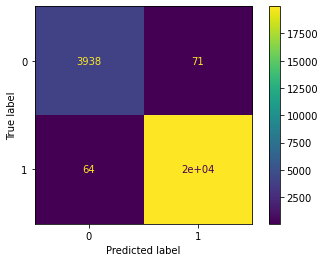

In [9]:
clf = RandomForestClassifier(criterion="entropy", n_estimators=150)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred, labels=clf.classes_)
print(cm)
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [10]:
clf_cv_score = cross_val_score(clf, x, y, cv=10, scoring="roc_auc")
clf_cv_score.mean()

0.998753035962532

<AxesSubplot:>

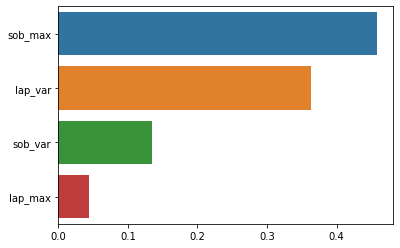

In [10]:
# Most important features
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

## Exporting Random Forest Model

In [ ]:
joblib.dump(clf, 'model.joblib')

# Testing Model on real images

In [45]:
# Loading pre-trained model
model = joblib.load('model.joblib')

# Reading image path and compute laplacian & sobel filter values
img_path = r'C:\Concat\blur_detection\test\test_8.jpg'
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lapvar, lapmax = varMaxLaplacian(gray)
sobvar, sobmax = varMaxSobel(gray)

Image is Blur with blurriness score of 0.81


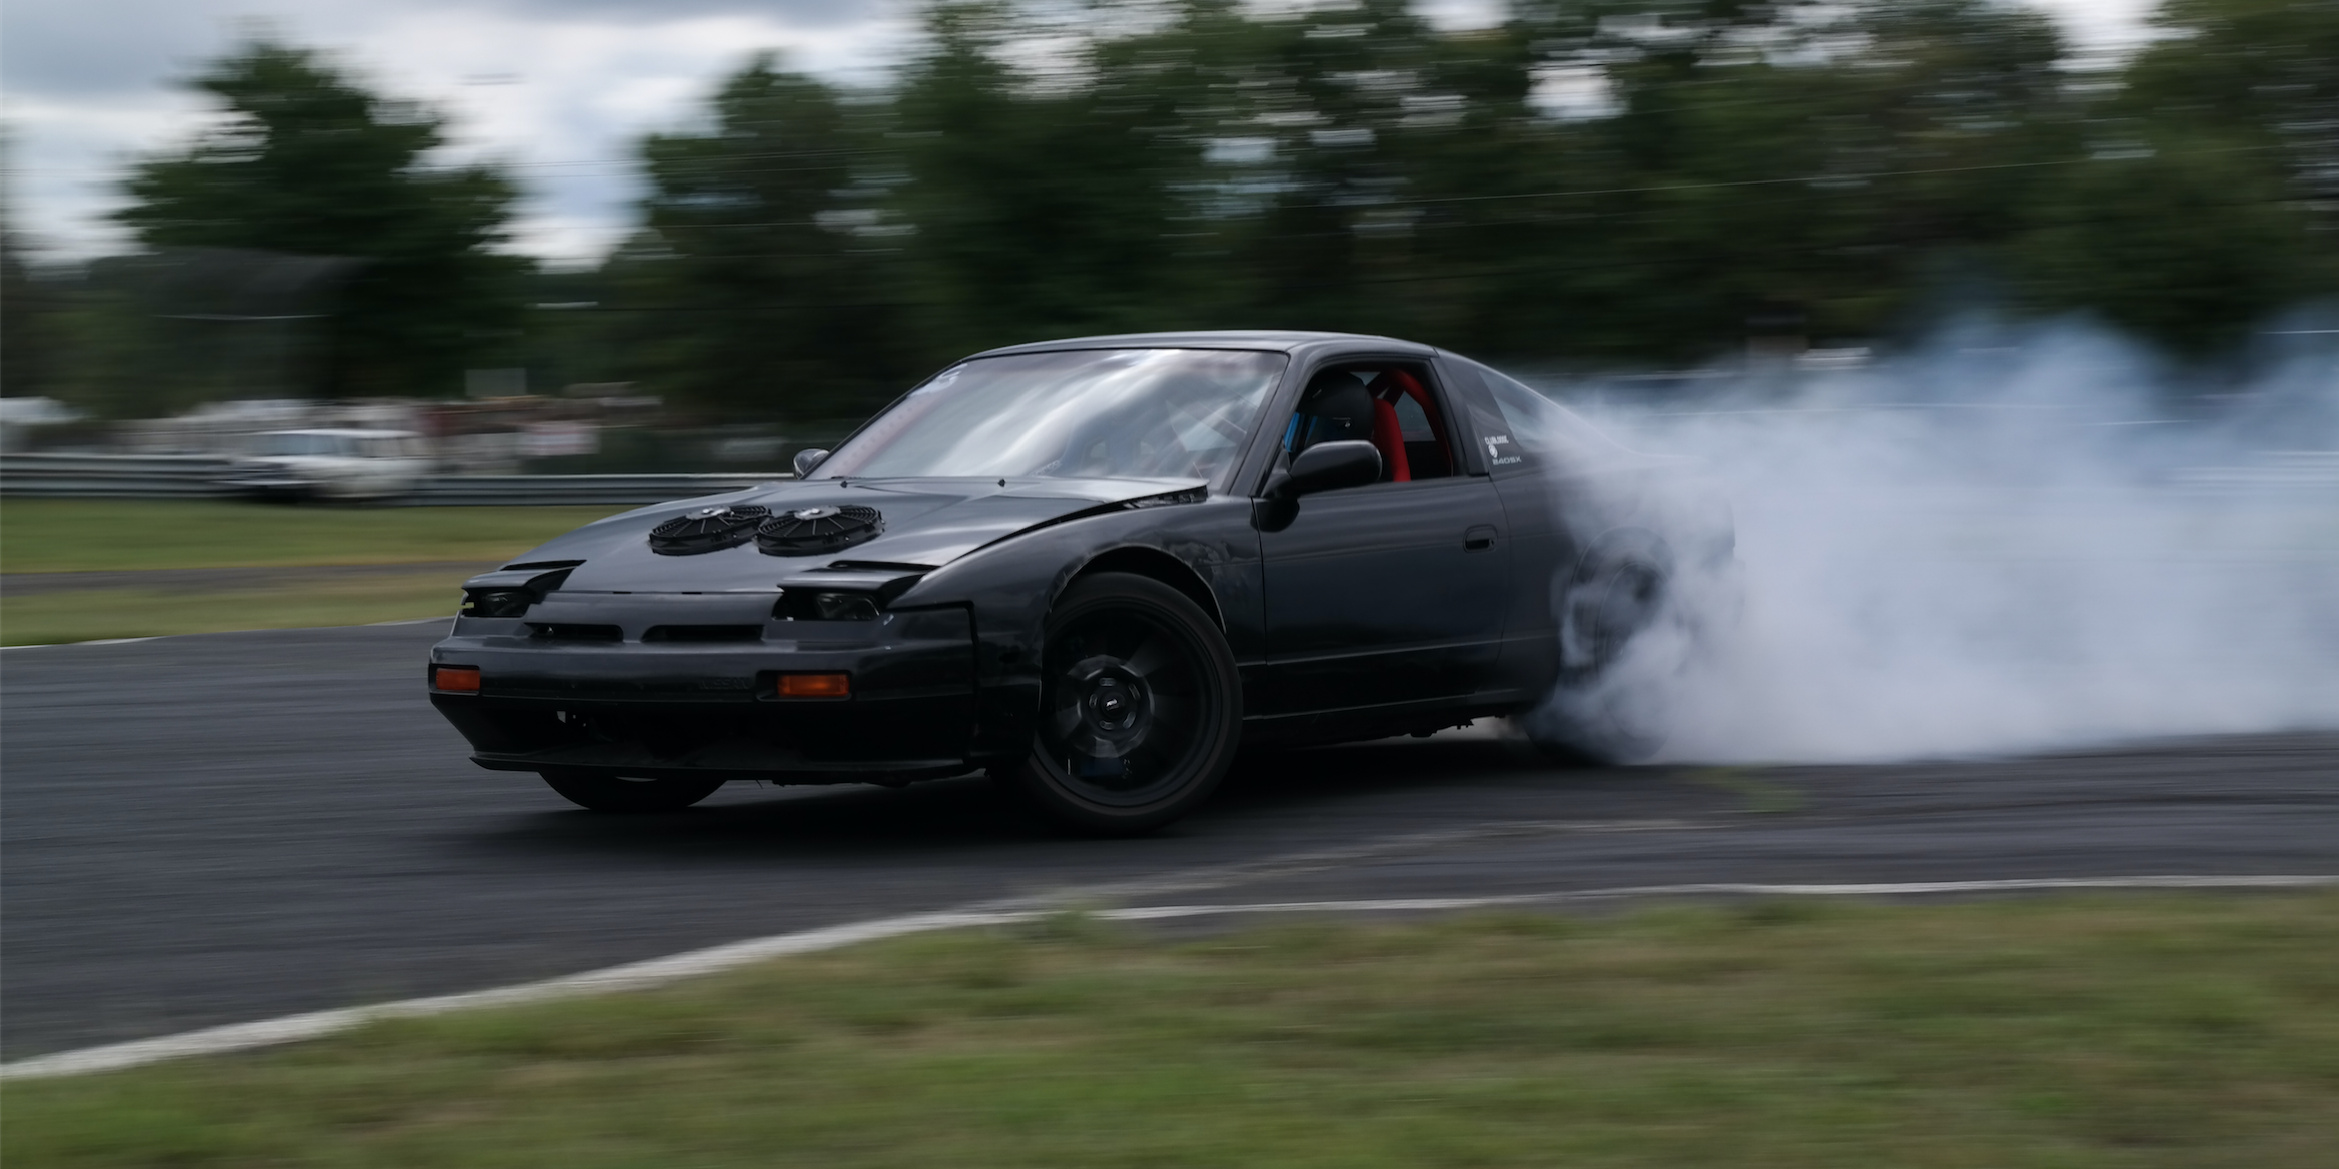

In [50]:
# Predicting class label and blurriness score
class_label = ["Clear" if model.predict([[lapmax, lapvar, sobmax, sobvar]])==0 else "Blur"]
blur_score = model.predict_proba([[lapmax, lapvar, sobmax, sobvar]])
print(f"Image is {''.join(class_label)} with blurriness score of {round(blur_score[0][1],2)}", )
Image.open(img_path)

# Error Analysis
## Lets analyze misclassified images. Start with images which are actually Blur but labeled as Clear images 

In [11]:
y_test_arr = np.array(y_test)
mislcassified = np.where(y_test_arr != clf.predict(X_test))

In [11]:
indices = [i for i in range(len(y_test)) if ((y_test[i]==1) & (y_pred[i]==0))]
wrong_preds = X_test.iloc[indices, :]

In [12]:
wrong_preds

lap_max     lap_var  sob_max        sob_var
62525    315.0  133.513782   8124.0  281972.179558
49630    370.0  143.783024   9920.0  228513.922224
39095    602.0  567.157394  10286.0  286730.588186
95165    308.0   92.216998   9964.0  244689.604367
35435    231.0   93.670647   9112.0  418314.248686
...        ...         ...      ...            ...
20490    391.0  163.608294   8540.0  450585.251505
11325    239.0  254.177052   6328.0  278256.487633
61465    504.0  394.373884   8988.0  191894.276228
85815    604.0  793.317385   7504.0  167459.089840
36105    414.0  182.245727   8732.0  131936.112826

[64 rows x 4 columns]

In [51]:
# index 62525 is one image where image is actually blur but predicted as clear
index = 62525
data_df['blur_label'][index]

1

Image is Clear with blurriness score of 0.46


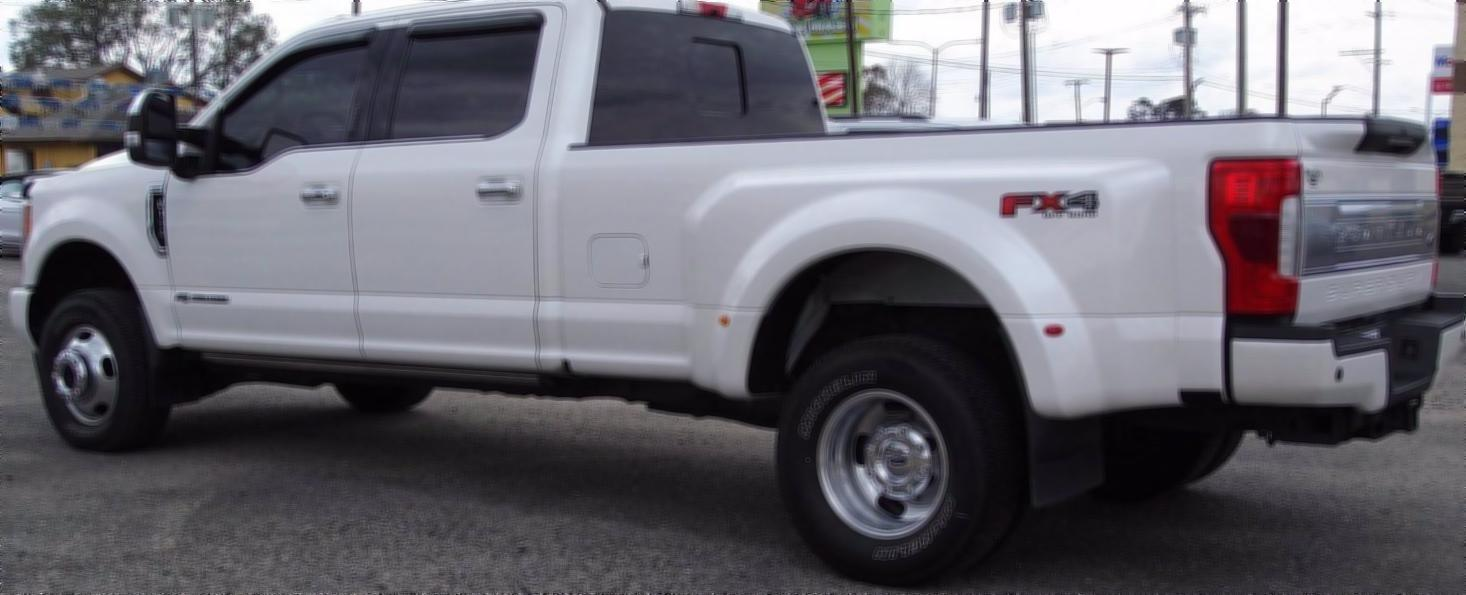

In [52]:

img_path = data_df['img_path'][index]
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
lapvar, lapmax = varMaxLaplacian(gray)
sobvar, sobmax = varMaxSobel(gray)
class_label = ["Clear" if model.predict([[lapmax, lapvar, sobmax, sobvar]])==0 else "Blur"]
blur_score = model.predict_proba([[lapmax, lapvar, sobmax, sobvar]])
print(f"Image is {''.join(class_label)} with blurriness score of {round(blur_score[0][1],2)}", )
Image.open(img_path)

On analyzing misclassified images, I realized that few ground truth images were mis-labeled. Correcting them woudl improve model performance. But, going through 20k clear images is difficult task and takes a lot of time & human labour. Also, few images which are actually blur  but predicted as clear like above, that could be because of blurriness score threshold level 0.5. As sir, Andrew NG suggests, data centric AI will help boost model performance by a greater margin. Cleaning the data and with robust feature engineering can help a lot in here. I just created a baseline model here to test few images and deploy it on Streamlit application.  